# Analysis of SD Score & Prediction of Forward Looking Scores

This notebook will focus on analyzing the SD Score and its potential to predict forward looking scores and DeFi yields. The data used will be from the DeFi Quant Data set. The data will be complemented with asset prices data.

The notebook will import both data sets, analyze and visualize the data.
The analysis will include: 

1. Describing the data
1. Cleaning the data
1. Joining the data sets
1. Creating new variables if needed
1. Visualizing the data
1. Correlation analysis and matrix
1. Transformation of variables if needed

From the analysis we will determine if SD score is a potential predictor of forward looking scores and DeFi yields.

The predicition models used will include:

1. Linear Regression
2. Random Forest
3. Gradient Boosting

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns



In [2]:
# Importing Data
filepath_data = '/Users/karolk/Python_Work/ML_Price/Datasets/DeFi_Quant_Data.csv'
filepath_prices = '/Users/karolk/Python_Work/ML_Price/Datasets/asset_prices.csv'

data = pd.read_csv(filepath_data)
prices = pd.read_csv(filepath_prices)

In [3]:
# getting head of stables
data.head()

,chain,project,symbol,tvlUsd,apy,pool,stablecoin,ilRisk,exposure,outlier,...,SD_Score_7D_std,SD_Score_7D_forward_rolling,SD_Score_7D_forward,SD_Score_7D_change,SD_Score_7D_forward_change,token_id_1,token_id_2,token_id_3,token_id_4,num_tokens
0,Base,uniswap-v3,ISK-WETH,113970.0,2.84529,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,0.957870,11.679788,11.537535,NaN,6.054964,ISK,WETH,NaN,NaN,2
1,Base,uniswap-v3,ISK-WETH,113706.0,0.58260,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,1.017590,11.782466,12.944821,18.474105,-5.552382,ISK,WETH,NaN,NaN,2
2,Base,uniswap-v3,ISK-WETH,112150.0,1.65160,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,0.980992,12.100888,14.572041,20.962385,-15.296104,ISK,WETH,NaN,NaN,2
3,Base,uniswap-v3,ISK-WETH,114564.0,1.54926,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,0.570777,12.524070,15.121374,25.373737,-19.589991,ISK,WETH,NaN,NaN,2
4,Base,uniswap-v3,ISK-WETH,117558.0,1.51888,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,0.537765,13.298774,16.642390,1.330580,-32.585007,ISK,WETH,NaN,NaN,2


### Importing Prices data and modifying it to merge with main data set

In [4]:

# creating date column for the prices data
# Remove the 'Z' at the end of the string in the 'createdAt' column (if it exists)
prices['date_created'] = prices['date_created'].str.replace('Z', '')

# convert the 'date_created' column to datetime
prices['date_created'] = pd.to_datetime(prices['date_created'], format='ISO8601')

# create date column in the format of 'YYYY-MM-DD'
prices['date'] = prices['date_created'].dt.date

# drop the 'date_created' column
prices = prices.drop(columns=['date_created'])

In [5]:
# create a column which is 7 day change in price calculated as today's price minus the price 7 days ago
# sort the data by assetSlug and date
prices = prices.sort_values(by=['assetSlug', 'date']).reset_index(drop=True)

# create a new column which is chang in price calculated as today's price minus the price 7 days ago
prices['7d_change'] = prices.groupby('assetSlug')['price'].diff(7)

In [6]:
# pivot the prices data for easier joining
prices_pivot = prices.pivot(index='date', columns='assetSlug', values='7d_change').reset_index()

# keep only the following columns
#prices_2_keep = ['avalanche', 'binance-smart-chain', 'cardano', 'celestia','cosmos', 'ethereum-2-0', 'fantom', 'injective-protocol','matic-network', 'near-protocol','solana',  'sui']

# keep only the columns in the 'prices_2_keep' list
#prices_pivot = prices_pivot[['date'] + prices_2_keep]

prices_pivot

assetSlug,date,avalanche,binance-smart-chain,cardano,celestia,cosmos,ethereum-2-0,fantom,injective-protocol,matic-network,near-protocol,solana,sui
0,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,2024-02-25,-2.78,37.90,-0.027002,-1.89,-0.19,239.40,-0.003108,-3.09,0.001271,0.19,-8.84,-0.15
421,2024-02-26,-0.17,49.81,-0.012805,-1.49,0.41,228.85,0.002463,-0.80,0.064439,0.56,-1.27,-0.10
422,2024-02-27,0.64,39.39,0.001142,-0.96,0.84,227.77,0.021470,3.69,0.002000,0.55,-0.52,-0.11
423,2024-02-28,2.41,35.75,0.029339,-0.91,1.42,389.34,0.070203,8.07,0.058134,0.63,11.45,-0.10


In [7]:
# Convert 'date' column in 'data' dataframe to datetime
data['date'] = pd.to_datetime(data['date'])

# Convert 'date' column in 'prices_pivot' dataframe to datetime
prices_pivot['date'] = pd.to_datetime(prices_pivot['date'].astype(str))

# Now you can merge
data = pd.merge(data, prices_pivot, on='date', how='left')

data


,chain,project,symbol,tvlUsd,apy,pool,stablecoin,ilRisk,exposure,outlier,...,cardano,celestia,cosmos,ethereum-2-0,fantom,injective-protocol,matic-network,near-protocol,solana,sui
0,Base,uniswap-v3,ISK-WETH,113970.0,2.84529,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,-0.013768,2.90,0.44,-151.94,-0.008622,9.42,-0.105119,-0.25,-3.17,-0.080119
1,Base,uniswap-v3,ISK-WETH,113706.0,0.58260,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,0.049448,1.66,1.01,-5.94,0.048742,12.77,-0.040764,0.05,4.12,-0.019494
2,Base,uniswap-v3,ISK-WETH,112150.0,1.65160,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,-0.000258,-0.55,-1.33,-25.62,0.004607,11.12,-0.123902,0.14,3.81,0.022224
3,Base,uniswap-v3,ISK-WETH,114564.0,1.54926,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,-0.069065,0.94,-0.89,-62.64,0.057837,13.45,-0.109557,0.53,11.26,0.034019
4,Base,uniswap-v3,ISK-WETH,117558.0,1.51888,0005d7bf-1f14-4c74-92cd-857c9931053e,False,yes,multi,False,...,-0.006240,-1.22,-0.11,-81.17,0.049528,9.85,-0.064111,1.20,18.03,0.033631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154631,Solana,raydium,UNKNOWN-SOL,18394.0,3.83000,fff61d0d-1ffd-43a8-b345-9743fbf3fb2a,False,yes,multi,True,...,-0.012901,-0.38,-0.54,-19.65,-0.049141,-4.32,0.093685,-0.26,-6.02,0.062107
154632,Solana,raydium,UNKNOWN-SOL,18789.0,0.21000,fff61d0d-1ffd-43a8-b345-9743fbf3fb2a,False,yes,multi,True,...,-0.002008,-2.41,-0.67,12.16,-0.058039,-4.97,0.117610,-0.16,-11.54,0.058702
154633,Solana,raydium,UNKNOWN-SOL,14202.0,1956.01000,fffc1e1e-0eeb-4f19-9617-b5b77822025e,False,yes,multi,True,...,-0.016290,-0.09,-0.41,-31.09,-0.017875,-2.86,0.094835,0.25,7.93,0.107159
154634,Solana,raydium,UNKNOWN-SOL,14202.0,1956.01000,fffc1e1e-0eeb-4f19-9617-b5b77822025e,False,yes,multi,True,...,-0.012901,-0.38,-0.54,-19.65,-0.049141,-4.32,0.093685,-0.26,-6.02,0.062107


### Modyfing the data set prior to starting the analysis and visualizations by adding new variables and cleaning the data

In [8]:
# defining columns to keep
columns_to_keep= [
    'date', 'apyMean7d', 'apyStd7d', 'apyChange7d', 'apy7DStdRatio', 'tvlChange7d',
    'SD_Score', 'SD_Score_7D_avg', 'SD_Score_7D_std', 'SD_Score_7D_change', 'SD_Score_7D_forward_change',
    'num_tokens', 'stablecoin','chain', 'project', 'tvlUsd', 'avalanche', 'binance-smart-chain', 'cardano', 'celestia',
    'cosmos', 'ethereum-2-0', 'fantom', 'injective-protocol','matic-network', 'near-protocol','solana',  'sui'
]

# keep only the columns in the 'columns_to_keep' list
data = data[columns_to_keep]

# chains to keep
chains_to_keep = ['Ethereum', 'Arbitrum', 'BSC', 'Polygon', 'Avalanche', 'Optimism', 'Solana', 'Base', 'Sui', 'Fantom' ]

# keep only the rows where the 'chain' column is in the 'chains_to_keep' list
data = data[data['chain'].isin(chains_to_keep)]

In [9]:
# turn the chain column into dummy variables
data = pd.get_dummies(data, columns=['chain'], drop_first=True)


In [10]:
# get project TVL by max date and sort the top 50 projects
tvl_by_project = data[data['date'] == data['date'].max()].groupby('project')['tvlUsd'].sum().sort_values(ascending=False).head(100)

# save the top 50 projects into a list
top_projects = tvl_by_project.index.to_list()

# keep only top 100 projects
data = data[data['project'].isin(top_projects)]

# drop the 'tvlUsd' column
data = data.drop(columns=['tvlUsd'])


In [11]:
# separate the 'proejct' column into 5 groups
data['project_group'] = np.where(data['project'].isin(tvl_by_project.head(10).index), 'Top 10', 
                                 np.where(data['project'].isin(tvl_by_project.head(20).index), 'Top 20', 
                                          np.where(data['project'].isin(tvl_by_project.head(30).index), 'Top 30', 
                                                   np.where(data['project'].isin(tvl_by_project.head(40).index), 'Top 40', 
                                                            np.where(data['project'].isin(tvl_by_project.head(50).index), 'Top 50', 'Other')))))
# turn the 'project_group' column into dummy variables
data = pd.get_dummies(data, columns=['project_group'], drop_first=True)

# drop the 'project' column
data = data.drop(columns=['project'])


In [12]:
# create a new variable which is 1 if 'SD_Score_7D_forward_change' is greater than 0, and 0 otherwise
data['SD_Score_7D_forward_change_binary'] = np.where(data['SD_Score_7D_forward_change'] > 0, 1, 0)

# for each of numeric variables in the data set i would like to turn them into log scale. For those that can potentially have negative values I will add a small constant to each value to make them all positive. I will analyze the variable individually.
variables_to_log = ['apyMean7d', 'apyStd7d', 'apyChange7d', 'apy7DStdRatio', 'tvlChange7d',
                    'SD_Score', 'SD_Score_7D_avg', 'SD_Score_7D_std', 'SD_Score_7D_change', 'SD_Score_7D_forward_change']

# keep only data where 'apyMean7d' is greater than 0.5
data = data[data['apyMean7d'] > 0.5]

# keep only data where 'apyStd7d' is greater than 0
data = data[data['apyStd7d'] > 0]

# remove any rows where 'TvlChange7d' is less than -90
data = data[data['tvlChange7d'] > -90]

# remove any rows where 'apyChange7d' is less than -90
data = data[data['apyChange7d'] > -90]

# remove rows where 'SD_Score_7D_change' is less than -90
data = data[data['SD_Score_7D_change'] > -90]

# remove any rows where the 'SD_Score_7D_forward_change' is less than -90
data = data[data['SD_Score_7D_forward_change'] > -90]

# check if there are any 0 or negative values in the variables
data[variables_to_log].min()


apyMean7d                      0.500810
apyStd7d                       0.000004
apyChange7d                  -89.997985
apy7DStdRatio                  0.377983
tvlChange7d                  -89.773349
SD_Score                       0.004312
SD_Score_7D_avg                0.005351
SD_Score_7D_std                0.002464
SD_Score_7D_change           -89.983506
SD_Score_7D_forward_change   -89.937369
dtype: float64

In [13]:

# creating a log of each variable
for variable in variables_to_log:
    # add a small constant to each value to make them all positive
    constant = 1 - data[variable].min()
    data[variable] = np.log1p(data[variable] + constant)
    

In [14]:
# checking if there any infinite values in the data


# Replace positive infinity values with NaN
data = data.replace([np.inf], np.nan)

# Replace negative infinity values with NaN
data = data.replace([-np.inf], np.nan)

# print count of nan values in each column
print(data.isna().sum())

# for loop to check if there are any infinite values in the data
for column in data.columns:
    if np.isinf(data[column]).any():
        print(f"Infinite value found in column: {column}")


date                                 0
apyMean7d                            0
apyStd7d                             0
apyChange7d                          0
apy7DStdRatio                        0
tvlChange7d                          0
SD_Score                             0
SD_Score_7D_avg                      0
SD_Score_7D_std                      0
SD_Score_7D_change                   0
SD_Score_7D_forward_change           0
num_tokens                           0
stablecoin                           0
avalanche                            0
binance-smart-chain                  0
cardano                              0
celestia                             0
cosmos                               0
ethereum-2-0                         0
fantom                               0
injective-protocol                   0
matic-network                        0
near-protocol                        0
solana                               0
sui                                  0
chain_Avalanche          

In [15]:
# extracting features from the date column
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_year'] = data['date'].dt.dayofyear

# drop the 'date' column
data = data.drop(columns=['date'])

In [16]:
data = data.dropna()


In [17]:
# remove outlier from the data using APY columns
# calculate the z-score for each value in the 'apyMean7d' column
data['z_apyMean7d'] = (data['apyMean7d'] - data['apyMean7d'].mean()) / data['apyMean7d'].std()

# keep only the rows where the absolute value of the z-score is less than 3
data = data[(data['z_apyMean7d'].abs() < 3)]

# drop the 'z_apyMean7d' column
data = data.drop(columns=['z_apyMean7d'])


### Visually Exploring the Data

In [18]:
# describe the data
data.describe()

,apyMean7d,apyStd7d,apyChange7d,apy7DStdRatio,tvlChange7d,SD_Score,SD_Score_7D_avg,SD_Score_7D_std,SD_Score_7D_change,SD_Score_7D_forward_change,...,matic-network,near-protocol,solana,sui,SD_Score_7D_forward_change_binary,year,month,day,day_of_week,day_of_year
count,71557.000000,71557.000000,71557.000000,71557.000000,71557.000000,71557.000000,71557.000000,71557.000000,71557.000000,71557.000000,...,71557.000000,71557.000000,71557.000000,71557.000000,71557.000000,71557.0,71557.0,71557.000000,71557.000000,71557.000000
mean,2.869444,2.165750,4.586636,1.802390,4.527177,3.234296,3.224236,1.305152,4.574963,4.536438,...,0.064281,0.816662,17.957431,0.092773,0.509845,2023.0,12.0,24.588510,3.020473,358.588510
std,1.369756,1.289970,1.301941,1.124561,0.360348,0.754237,0.759345,0.402406,0.512878,0.459986,...,0.117013,0.748458,17.533192,0.063654,0.499907,0.0,0.0,3.998907,1.993635,3.998907
min,0.693147,0.693147,0.693147,0.693202,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,-0.123902,-0.260000,-11.540000,-0.019494,0.000000,2023.0,12.0,18.000000,0.000000,352.000000
25%,1.798918,1.099506,4.005382,1.138871,4.449187,2.765973,2.753283,1.001857,4.400086,4.397702,...,-0.040764,0.140000,4.120000,0.034019,0.000000,2023.0,12.0,21.000000,1.000000,355.000000
50%,2.667309,1.788130,4.521810,1.428817,4.522205,3.375638,3.363644,1.209426,4.521403,4.524785,...,0.093685,1.170000,18.030000,0.107159,1.000000,2023.0,12.0,25.000000,3.000000,359.000000
75%,3.792333,2.970292,5.027098,2.114556,4.606167,3.823158,3.817788,1.514658,4.682365,4.667405,...,0.117610,1.550000,34.610000,0.118685,1.000000,2023.0,12.0,28.000000,5.000000,362.000000
max,7.196346,7.990047,17.831148,13.953319,11.184638,4.553594,4.561678,3.475985,12.549133,12.045842,...,0.263828,1.990000,46.840000,0.208804,1.000000,2023.0,12.0,31.000000,6.000000,365.000000


In [19]:
# view data
data.head(25)

,apyMean7d,apyStd7d,apyChange7d,apy7DStdRatio,tvlChange7d,SD_Score,SD_Score_7D_avg,SD_Score_7D_std,SD_Score_7D_change,SD_Score_7D_forward_change,...,project_group_Top 20,project_group_Top 30,project_group_Top 40,project_group_Top 50,SD_Score_7D_forward_change_binary,year,month,day,day_of_week,day_of_year
1,1.495389,1.308118,3.330126,1.213461,4.517187,2.654773,2.581582,1.103642,4.704632,4.458814,...,False,False,False,False,0,2023,12,18,0,352
2,1.469080,1.325822,4.078704,1.173796,4.553531,2.662967,2.604436,1.091429,4.726909,4.339136,...,False,False,False,False,0,2023,12,19,1,353
3,1.453299,1.337830,4.226637,1.149362,4.558969,2.650053,2.630099,0.943250,4.765223,4.281479,...,False,False,False,False,0,2023,12,20,2,354
4,1.355082,1.313862,3.301722,1.099976,4.570183,2.581364,2.631615,0.930312,4.535971,4.083492,...,False,False,False,False,0,2023,12,21,3,355
5,1.363563,1.315853,4.613651,1.104354,4.526151,2.600649,2.636167,0.888756,4.564408,4.121674,...,False,False,False,False,0,2023,12,22,4,356
6,1.317076,1.202646,4.260972,1.194697,4.548022,2.548832,2.622800,0.958861,4.397595,4.082618,...,False,False,False,False,0,2023,12,23,5,357
7,1.383641,1.283948,5.044735,1.153067,4.554958,2.605148,2.615528,0.947020,4.457531,4.249957,...,False,False,False,False,0,2023,12,24,6,358
8,1.519415,1.263853,6.670837,1.285647,4.559649,2.704076,2.623009,1.005581,4.583561,4.413182,...,False,False,False,False,0,2023,12,25,0,359
9,1.608835,1.251094,5.610055,1.376997,4.576771,2.807457,2.645858,1.190588,4.700861,4.580959,...,False,False,False,False,1,2023,12,26,1,360
10,1.652432,1.179235,5.260647,1.524729,4.567125,2.840076,2.675439,1.314666,4.756570,4.679341,...,False,False,False,False,1,2023,12,27,2,361


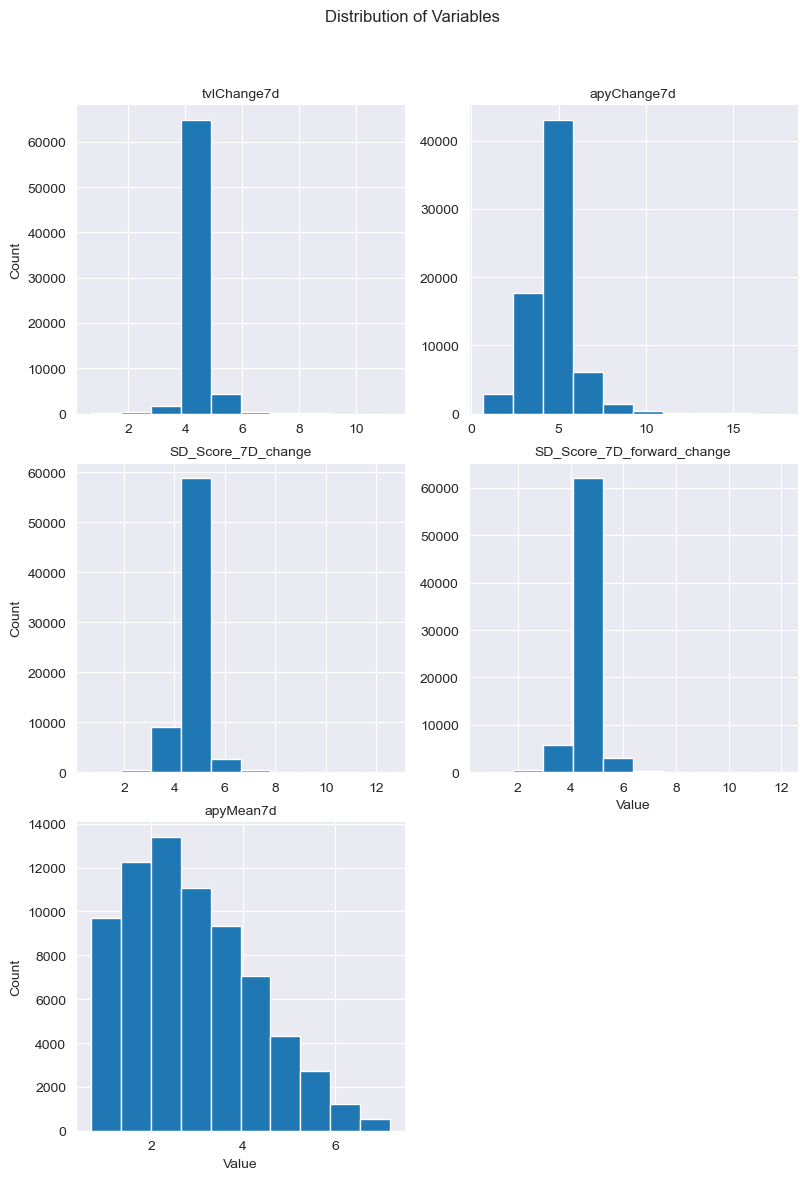

In [20]:
# Data Visualization - creating a facet grid using seaborn to visualize the data.. I will use histograms to visualize the distribution of the data for each variable

# selecting data to visualize
data_facetgrid = data[['tvlChange7d', 'apyChange7d', 'SD_Score_7D_change', 'SD_Score_7D_forward_change',  'apyMean7d']]


# melting the data to create a long dataframe with 2 columns: variable and value
data_facetgrid = pd.melt(data_facetgrid,
                         var_name='variable',
                         value_name='value')

# creating a facet grid with seaborn
g = sns.FacetGrid(data_facetgrid, col='variable', col_wrap=2, height=4, sharey=False, sharex=False)
g.map(plt.hist, 'value', bins=10) # adjust bin number here as needed

# setting the title and axis labels
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Variables')
g.set_titles('{col_name}')

# adding labels to the x-axis and y-axis
g.set_axis_labels(x_var='Value', y_var='Count')

# show the plot
plt.show()

/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karolk/anaconda3/envs/ML_Price/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

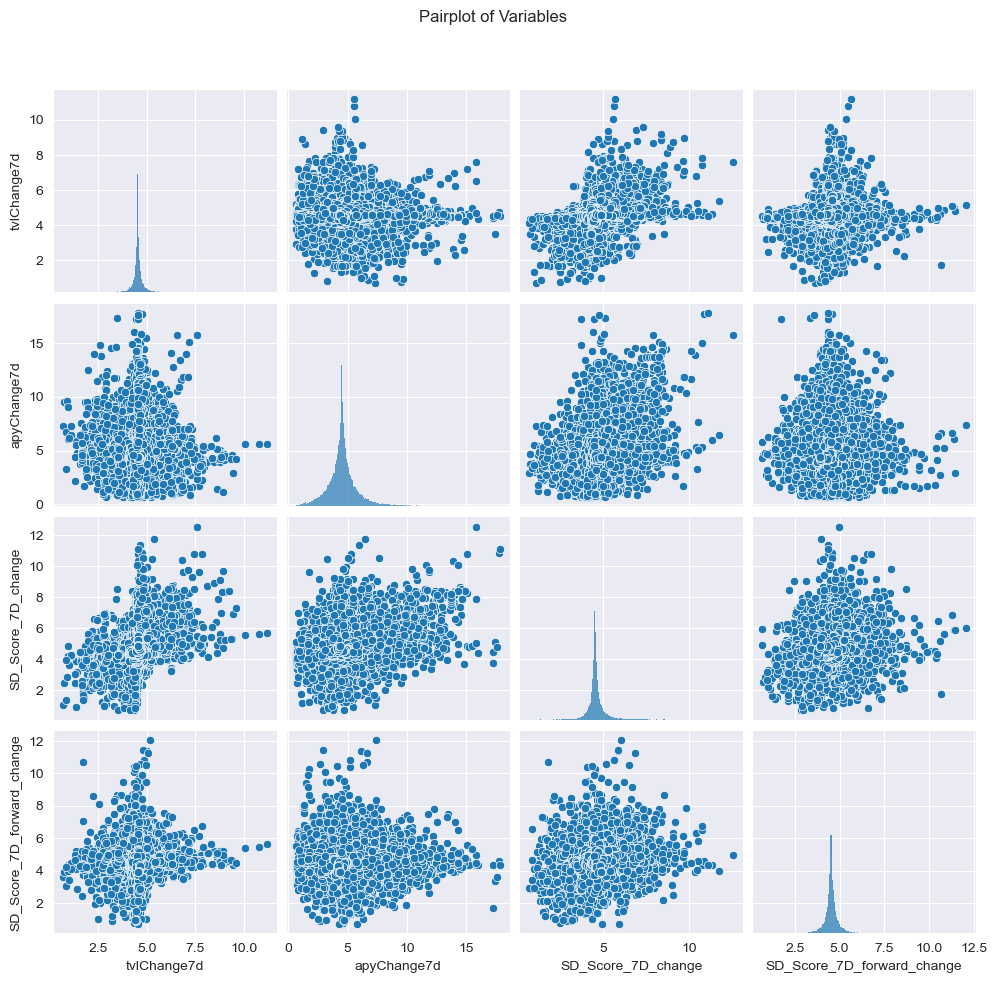

In [21]:
# Data Visualization - creating a pairplot using seaborn to visualize the data.. I will use pairplot to visualize the relationship between the variables

# selecting data to visualize
data_pairplot = data[['tvlChange7d', 'apyChange7d', 'SD_Score_7D_change', 'SD_Score_7D_forward_change', ]]

# Replace positive and negative infinity with NaN
data_pairplot = data_pairplot.replace([np.inf, -np.inf], np.nan)

# Now you can create your pairplot without warnings
g = sns.pairplot(data_pairplot)

# setting the title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Pairplot of Variables')

# show the plot
plt.show()

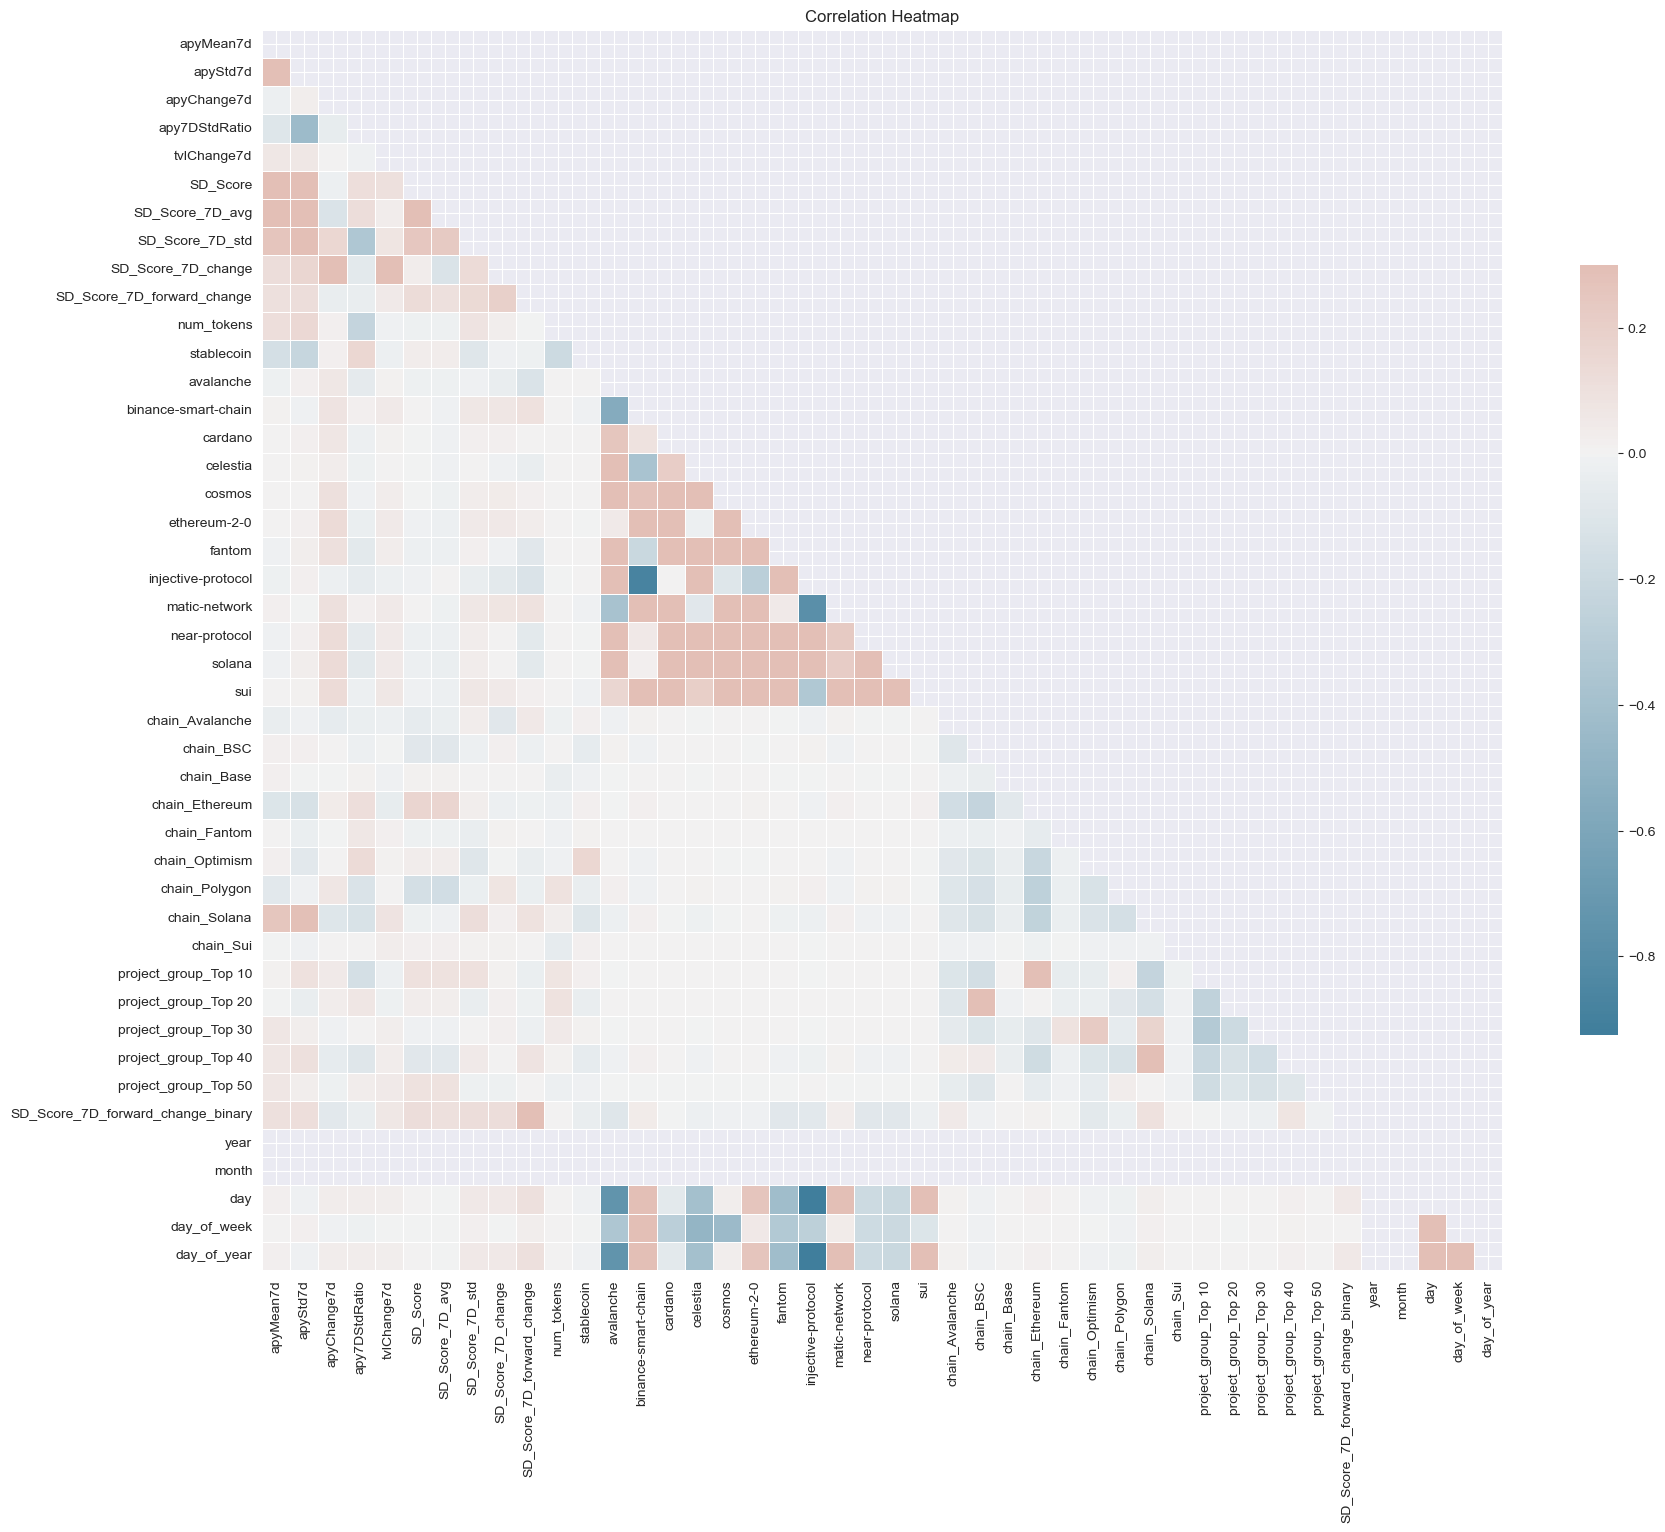

In [22]:
# Data Visualization - creating a heatmap using seaborn to visualize the correlation between the variables

# calculate the correlation matrix
corr = data.corr()

# create a mask to only show the lower triangle of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# create a custom diverging color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# create the heatmap
plt.figure(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# setting the title
plt.title('Correlation Heatmap')
    
# show the plot
plt.show()

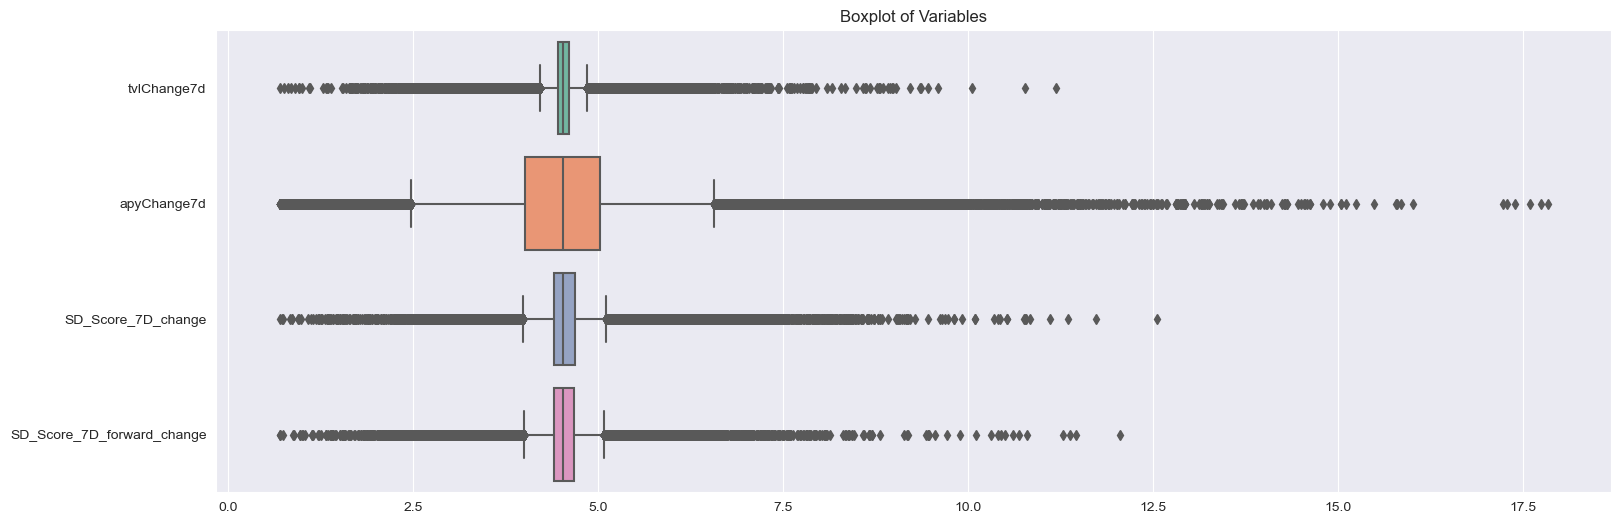

In [23]:
# Data Visualization - creating a boxplot using seaborn to visualize distibution of the variables

# selecting data to visualize
data_boxplot = data_pairplot

# creating a boxplot with seaborn
plt.figure(figsize=(18, 6))
sns.boxplot(data=data_boxplot, orient="h", palette="Set2")

# setting the title
plt.title('Boxplot of Variables')

# show the plot
plt.show()

### Machine Learning - Defining Data Set for Prediction

Defining the models of how to proceed.

I will use two features to predict. 
1. SD_Score_7D_forward_change
1. SD_Score_7D_forward_change_binary

Starting with SD_Score_7D_forward_change. The models will be:

1. Linear Regression
1. Linear Regression (Lasso)
1. Linear Regression using cross validation
1. Decision Tree Regressor
1. Random Forest Regressor
1. Gradient Boosting Regressor

For each of the models I will save and evaluate the mean squared error, r2 score and the feature importance.

Next, I will use SD_Score_7D_forward_change_binary. The models will be:

1. Logistic Regression (removed due to iteration limit)
1. Decision Tree Classifier
1. Random Forest Classifier 
1. Voting Classifier
1. AdaBoost Classifier

For each of the models I will save and evaluate the accuracy, precision, recall, f1 score and the feature importance.

## Preddiction of SD_Score_7D_forward_change

In [24]:
# Variable definition for the models and splitting the data
from sklearn.model_selection import train_test_split

# define the features and the target variable
X = data.drop(columns=['SD_Score_7D_forward_change', 'SD_Score_7D_forward_change_binary'])
y = data['SD_Score_7D_forward_change']
y_binary = data['SD_Score_7D_forward_change_binary']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# split the data into training and testing sets
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.3, random_state=69)

In [25]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# create the model
model = LinearRegression()

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# calculate the r2 score
r2 = r2_score(y_test, y_pred)

# print the mean squared error and r2 score with the model name
print(f'Linear Regression Mean Squared Error: {mse:.2f}')
print(f'Linear Regression R2 Score: {r2:.2f}')

Linear Regression Mean Squared Error: 0.19
Linear Regression R2 Score: 0.11


In [26]:
# Linear Regression (Lasso)
from sklearn.linear_model import Lasso

# create the model
model = Lasso()

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# calculate the r2 score
r2 = r2_score(y_test, y_pred)

# print the mean squared error and r2 score with the model name
print(f'Lasso Mean Squared Error: {mse:.2f}')
print(f'Lasso R2 Score: {r2:.2f}')


Lasso Mean Squared Error: 0.21
Lasso R2 Score: -0.00


In [27]:
# Linear Regression using cross validation
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# create the model
model = LinearRegression()

# use cross_val_score function
scores = cross_val_score(model, X_train, y_train, cv=5)

# print the mean and standard deviation of the cross-validation scores
print(f'Cross-Validation Mean: {scores.mean():.2f}')
print(f'Cross-Validation Standard Deviation: {scores.std():.2f}')



Cross-Validation Mean: 0.11
Cross-Validation Standard Deviation: 0.01


In [28]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

# create the model
model = DecisionTreeRegressor()

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# calculate the r2 score
r2 = r2_score(y_test, y_pred)

# print the mean squared error and r2 score with the model name
print(f'Decision Tree Regressor Mean Squared Error: {mse:.2f}')
print(f'Decision Tree Regressor R2 Score: {r2:.2f}')

Decision Tree Regressor Mean Squared Error: 0.30
Decision Tree Regressor R2 Score: -0.43


In [29]:
# Random Forest Regressor  
from sklearn.ensemble import RandomForestRegressor

# create the model
model = RandomForestRegressor()

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# calculate the r2 score
r2 = r2_score(y_test, y_pred)

# print the mean squared error and r2 score with the model name
print(f'Random Forest Regressor Mean Squared Error: {mse:.2f}')
print(f'Random Forest Regressor R2 Score: {r2:.2f}')

Random Forest Regressor Mean Squared Error: 0.14
Random Forest Regressor R2 Score: 0.32


In [30]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# create the model
model = GradientBoostingRegressor()

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# calculate the r2 score
r2 = r2_score(y_test, y_pred)

# print the mean squared error and r2 score with the model name
print(f'Gradient Boosting Regressor Mean Squared Error: {mse:.2f}')
print(f'Gradient Boosting Regressor R2 Score: {r2:.2f}')

Gradient Boosting Regressor Mean Squared Error: 0.17
Gradient Boosting Regressor R2 Score: 0.18


## Preddiction of SD_Score_7D_forward_change_binary

In [31]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# create the model
model = DecisionTreeClassifier()

# fit the model on the training data
model.fit(X_train_bin, y_train_bin)

# make predictions on the testing data
y_pred = model.predict(X_test_bin)

# calculate the accuracy
accuracy = model.score(X_test_bin, y_test_bin)

# print the accuracy with the model name
print(f'Decision Tree Classifier Accuracy: {accuracy:.2f}')

# print the precision, recall, and f1 score
precision = precision_score(y_test_bin, y_pred)

recall = recall_score(y_test_bin, y_pred)

f1 = f1_score(y_test_bin, y_pred)

print(f'Decision Tree Classifier Precision: {precision:.2f}')
print(f'Decision Tree Classifier Recall: {recall:.2f}')
print(f'Decision Tree Classifier F1 Score: {f1:.2f}')

Decision Tree Classifier Accuracy: 0.64
Decision Tree Classifier Precision: 0.64
Decision Tree Classifier Recall: 0.65
Decision Tree Classifier F1 Score: 0.64


In [32]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# create the model
model = RandomForestClassifier()

# fit the model on the training data
model.fit(X_train_bin, y_train_bin)

# make predictions on the testing data
y_pred = model.predict(X_test_bin)

# calculate the accuracy
accuracy = model.score(X_test_bin, y_test_bin)

# print the accuracy with the model name
print(f'Random Forest Classifier Accuracy: {accuracy:.2f}')

# print the precision, recall, and f1 score
precision = precision_score(y_test_bin, y_pred)

recall = recall_score(y_test_bin, y_pred)

f1 = f1_score(y_test_bin, y_pred)

print(f'Random Forest Classifier Precision: {precision:.2f}')
print(f'Random Forest Classifier Recall: {recall:.2f}')
print(f'Random Forest Classifier F1 Score: {f1:.2f}')

Random Forest Classifier Accuracy: 0.72
Random Forest Classifier Precision: 0.72
Random Forest Classifier Recall: 0.73
Random Forest Classifier F1 Score: 0.72


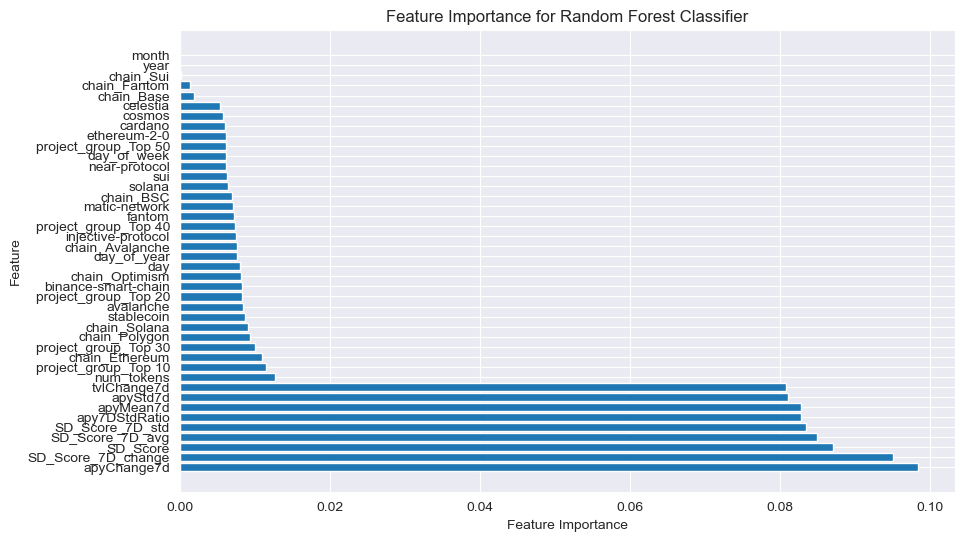

In [33]:
# determine feature importance
importance = model.feature_importances_

# create a dictionary of feature importance
feature_importance = dict(zip(X.columns, importance))

# sort the feature importance dictionary
feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

    
# plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), list(feature_importance.values()), align='center')
plt.yticks(range(len(feature_importance)), list(feature_importance.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Classifier')
plt.show()
#%

In [34]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# create the models
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bin)
X_test_scaled = scaler.transform(X_test_bin)

# create the voting classifier
model = VotingClassifier(estimators=[('dt', model2), ('rf', model3)], voting='soft')

# fit the model on the training data
model.fit(X_train_scaled, y_train_bin)

# make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# calculate the accuracy
accuracy = model.score(X_test_scaled, y_test_bin)

# print the accuracy with the model name
print(f'Voting Classifier Accuracy: {accuracy:.2f}')

# print the precision, recall, and f1 score
precision = precision_score(y_test_bin, y_pred)

recall = recall_score(y_test_bin, y_pred)

f1 = f1_score(y_test_bin, y_pred)

print(f'Voting Classifier Precision: {precision:.2f}')
print(f'Voting Classifier Recall: {recall:.2f}')
print(f'Voting Classifier F1 Score: {f1:.2f}')

Voting Classifier Accuracy: 0.64
Voting Classifier Precision: 0.64
Voting Classifier Recall: 0.65
Voting Classifier F1 Score: 0.64


In [35]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

# create the model
model = AdaBoostClassifier()

# fit the model on the training data
model.fit(X_train_bin, y_train_bin)

# make predictions on the testing data
y_pred = model.predict(X_test_bin)

# calculate the accuracy
accuracy = model.score(X_test_bin, y_test_bin)

# print the accuracy with the model name
print(f'AdaBoost Classifier Accuracy: {accuracy:.2f}')

# print the precision, recall, and f1 score
precision = precision_score(y_test_bin, y_pred)

recall = recall_score(y_test_bin, y_pred)
    
f1 = f1_score(y_test_bin, y_pred)

print(f'AdaBoost Classifier Precision: {precision:.2f}')
print(f'AdaBoost Classifier Recall: {recall:.2f}')
print(f'AdaBoost Classifier F1 Score: {f1:.2f}')


AdaBoost Classifier Accuracy: 0.63
AdaBoost Classifier Precision: 0.62
AdaBoost Classifier Recall: 0.66
AdaBoost Classifier F1 Score: 0.64
